Data shape: (200000, 784) Labels: (200000,)
X_train: (136000, 28, 28, 1)
X_valid: (24000, 28, 28, 1)
X_test: (40000, 28, 28, 1)


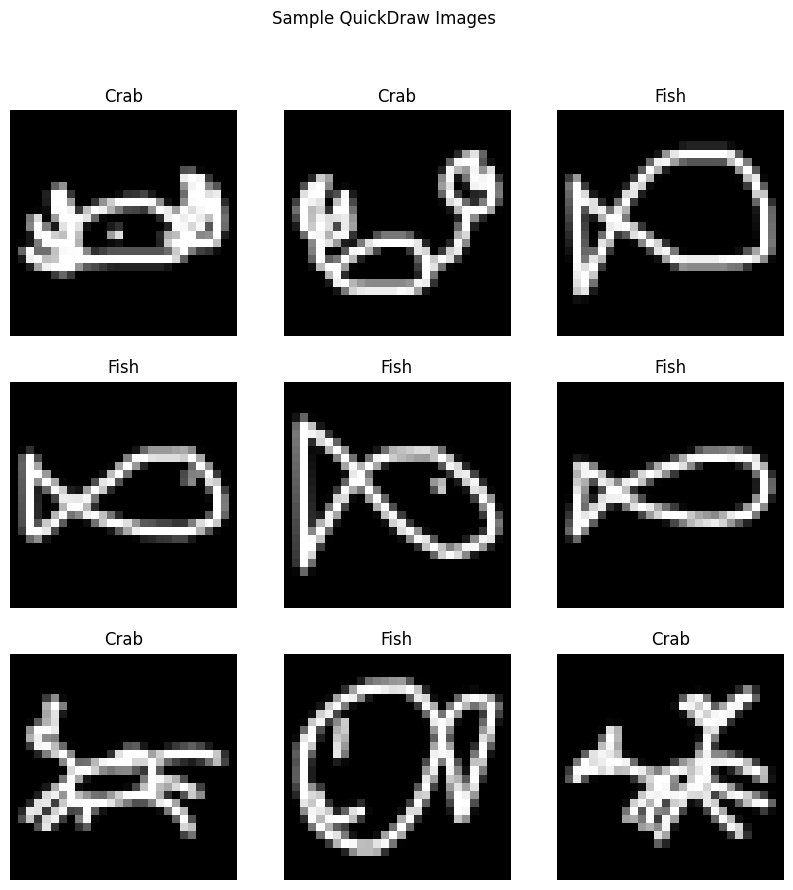

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

Epoch 1/20
4250/4250 - 23s - loss: 0.0932 - accuracy: 0.9633 - val_loss: 0.0600 - val_accuracy: 0.9758 - 23s/epoch - 5ms/step
Epoch 2/20
4250/4250 - 26s - loss: 0.0546 - accuracy: 0.9776 - val_loss: 0.0509 - val_accuracy: 0.9787 - 26s/epoch - 6ms/step
Epoch 3/20
4250/4250 - 26s - loss: 0.0434 - accuracy: 0.9822 - val_loss: 0.0519 - val_accuracy: 0.9780 - 26s/epoch - 6ms/step
Epoch 4/20
4250/4250 - 27s - loss: 0.0342 - accuracy: 0.9860 - val_loss: 0.0529 - val_accuracy: 0.9802 - 27s/epoch - 6ms/step
Epoch 5/20
4250/4250 - 26s - loss: 0.0262 - accuracy: 0.9897 - val_loss: 0.0598 - val_accuracy: 0.9785 - 26s/epoch - 6ms/step
Epoch 6/20
4250/4250 - 24s - loss: 0.0204 - accuracy: 0.9918 - val_loss: 0.0724 - val_accuracy: 0.9794 - 24s/epoch - 6ms/step
Epoch 7/20
Restoring model weights from the end of the best epoch: 2.
4250/4250 - 24s - loss: 0.0152 - accuracy: 0.9940 - val_loss: 0.0791 - val_accuracy: 0.9790 - 24s/epoch - 6ms/step
Epoch 7: early stopping

Test Accuracy: 0.9795
Test Loss: 0

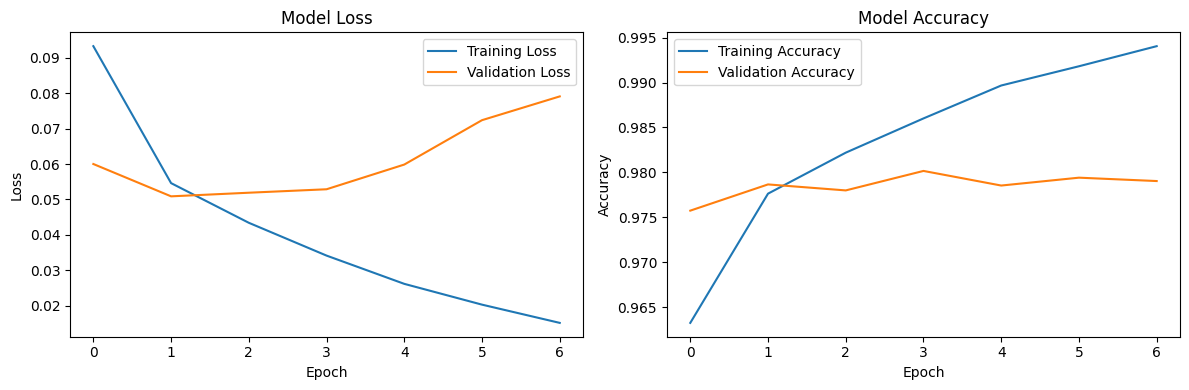

Training history saved as 'training_history.pkl'


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Need this for my laptop
tf.config.set_visible_devices([], 'GPU')
tf.config.list_physical_devices()
tf.config.list_logical_devices()

# Dataset settings
DATA_DIR = "quickdraw_simplified"
CATEGORIES = ["crab", "fish"]
IMG_SIZE = 28
N_PER_CLASS = 100000

# Load QuickDraw data
X, y = [], []
for idx, category in enumerate(CATEGORIES):
    file_path = os.path.join(DATA_DIR, f"{category}.npy")
    data = np.load(file_path)

    # Limit number of samples per class
    data = data[:N_PER_CLASS]

    data = data.reshape(data.shape[0], -1)

    # Normalize to [0,1]
    data = data / 255.0

    X.append(data)
    y.extend([idx] * len(data))

# Combine all categories
X = np.vstack(X)
y = np.array(y)
print("Data shape:", X.shape, "Labels:", y.shape)

# Reshape back to image format (28,28,1) for CNN
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Split into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=42, stratify=y_train_val
)

print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)
print("X_test:", X_test.shape)

# Define class names for plotting
class_names = ["Crab", "Fish"]

# Show sample images
plt.figure(figsize=(10, 10))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(X_train[i].reshape(28, 28), cmap="gray")
    plt.title(class_names[y_train[i]])
    plt.axis("off")
plt.suptitle("Sample QuickDraw Images")
plt.show()

# Define CNN model
model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(2, activation="softmax")  # Two output classes
])

model.summary()

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stop],
    verbose=2
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Save trained model (Keras format)
model.save("quickdraw_crab_fish_model_clean.keras")

# Save training history
joblib.dump(history.history, "training_history.pkl")
print("Training history saved as 'training_history.pkl'")

1/1 [==============================] - 0s 12ms/step


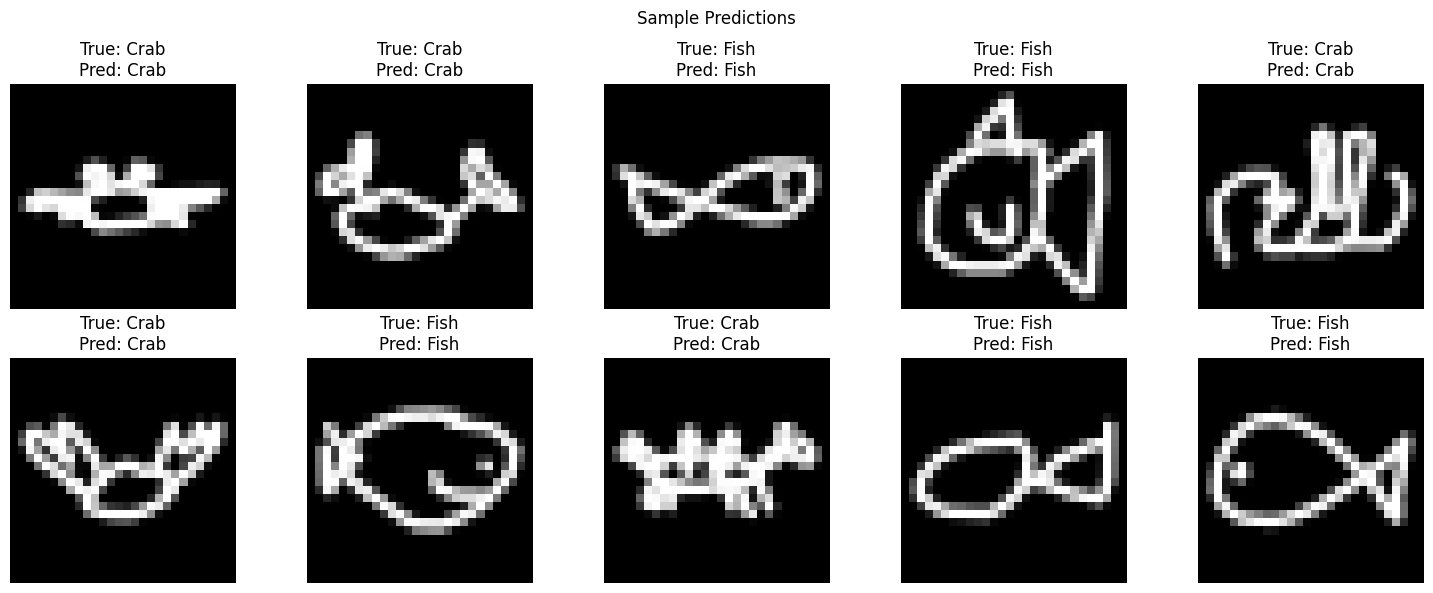

In [10]:
# Make predictions on some test samples
n_samples_to_show = 10
sample_indices = np.random.choice(len(X_test), n_samples_to_show, replace=False)
sample_images = X_test[sample_indices]
sample_labels = y_test[sample_indices]

predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)



# Display predictions
plt.figure(figsize=(15, 6))
for i in range(n_samples_to_show):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {class_names[sample_labels[i]]}\nPred: {class_names[predicted_classes[i]]}")
    plt.axis('off')
plt.suptitle("Sample Predictions")
plt.tight_layout()
plt.show()